# Validation of Coordinate Transformations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('./src')

from data_queries import  getClusterInfo, getGAIAKnownMembers
from gaiastars import gaiastars as gs

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Cone Search Parameters

In [2]:
cone_search_center=(77.0, -8.0); search_radius=7.5 #degree
#Kun et al (2001) distance: 210 pc +/- 20pc
#keep distance between 100 and 300 pc
dist_constraint=(100,300) #pc
plx_hi = 1000.0/dist_constraint[0]
plx_lo = 1000.0/dist_constraint[1]
(plx_lo, plx_hi)

(3.3333333333333335, 10.0)

In [3]:
search_results=gs(name="conesearch near witch head nebula")
search_results.conesearch(cone_search_center[0]*u.degree, cone_search_center[1]*u.degree,search_radius*u.degree, parallax=(plx_lo, plx_hi))
len(search_results)

INFO: Query finished. [astroquery.utils.tap.core]


16218

## Just Results with Radial Velocity (for now)

In [4]:
print(f"Search Results with RV: {np.isfinite(search_results.objs.radial_velocity).sum()}, total stars: {len(search_results)}")

search_results.objs['hasRV'] = np.isfinite(search_results.objs.radial_velocity)

search_results_rv = search_results.query('hasRV')

Search Results with RV: 3042, total stars: 16218


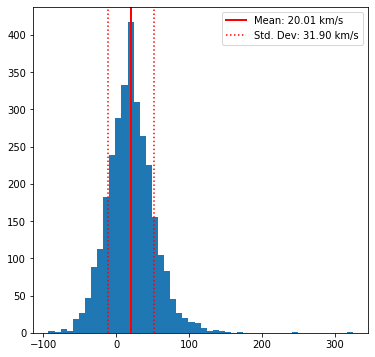

In [5]:
rv_mean = search_results_rv.objs.radial_velocity.mean()
rv_sd = search_results_rv.objs.radial_velocity.std()
fig = plt.figure(figsize=(6,6))
ax=fig.add_subplot()
ax.hist(search_results_rv.objs.radial_velocity, bins=50)
ax.axvline(rv_mean, lw=2, label=f'Mean: {rv_mean:.2f} km/s', color='red')
ax.axvline(rv_mean-rv_sd, ls=':', label=f'Std. Dev: {rv_sd:.2f} km/s', color='red')
ax.axvline(rv_mean+rv_sd, ls=':', color='red')
ax.legend()

In [6]:
from transforms import pm_to_dxyz, dxyz_to_pm, spherical_to_cartesian, cartesian_to_spherical

## Spherical to Cartesian

In [7]:
objs = search_results_rv.objs
calc_xyz = spherical_to_cartesian(objs.ra, objs.dec, objs.r_est)
coords = search_results_rv.get_coords()
ap_xyz = coords.cartesian.xyz.value
np.allclose(calc_xyz, ap_xyz)

True

## Cartesian to Spherical

In [8]:
objs = search_results_rv.objs
calc_spherical = cartesian_to_spherical(calc_xyz)
print('All close RA: {} '.format(np.allclose(calc_spherical['alpha'],objs.ra)))
print('All close Dec: {} '.format(np.allclose(calc_spherical['delta'],objs.dec)))
print('All close Distance: {} '.format(np.allclose(calc_spherical['distance'],objs.r_est)))

All close RA: True 
All close Dec: True 
All close Distance: True 


## PM to D_XYZ
__Use Cases__
1.  Arguments all same length; compute d_xyz for each; return 3xlen(RA), (one col for each element)
2.  All except RV scalar, RV vector: compute d_xyz for each RV, return 3xlen(RV) (one col for each rv)
3.  All scalar: compute one d_xyz return column vector

In [13]:
degree_per_mas = 2.7777777777777776e-07
seconds_per_year = 31557600.0
pc_per_km = 3.240779289469756e-14

def pm_to_dxyz(ra_arg, dec_arg, distance_arg,
               pm_ra_cosdec_arg, pm_dec_arg, radial_velocity_arg):
    """
    computes d_xyz from ra, dec,d distance, pmra_cosdec and pm_dec, given a sample of radial velocity
    Arguemnts:
        ra, dec: ra and dec in degrees;
        distance: distance to object in pc;
        pm_ra_cosdec, pm_dec: proper motions in mas/year
        radial_velocity: in km/s, possibly a vector of these
    Returns np.array(3,) if radial velocity is scalar , np.array(3, len(radial_velocity)) of d_x, d_y and d_z  
    """
    
    
    #fix up the arguments
    radial_velocity = radial_velocity_arg if hasattr(radial_velocity_arg,"__len__") \
           else np.arary([radial_velocity_arg])
    n =  len(radial_velocity)
    
    ra   = ra_arg if hasattr(ra_arg,"__len__") else np.full(n, ra_arg)
    dec  = dec_arg if hasattr(dec_arg,"__len__") else np.full(n, dec_arg)
    distance = distance_arg if hasattr(distance_arg,"__len__") else np.full(n, distance_arg)
    pm_ra_cosdec = pm_ra_cosdec_arg if hasattr(pm_ra_cosdec_arg,"__len__") else np.full(n, pm_ra_cosdec_arg)
    pm_dec = pm_dec_arg if hasattr(pm_dec_arg,"__len__") else np.full(n, pm_dec_arg)
    
    print(f'ra.shape: {ra.shape}')
    print(f'dec.shape: {dec.shape}')    
    print(f'distance.shape: {distance.shape}')
    print(f'pm_ra_cosdec.shape: {pm_ra_cosdec.shape}')
    print(f'pm_dec.shape: {pm_dec.shape}')
    print(f'radial_velocity.shape: {radial_velocity.shape}')
    
    assert np.all(np.array([len(ra), len(dec), len(distance), len(pm_ra_cosdec),
                            len(pm_dec), len(radial_velocity)]) == n)
    
    return

    #get some radians
    rarad = np.radians(ra);
    decrad = np.radians(dec)
    pmrarad = np.radians(pm_ra_cosdec*degree_per_mas) # radians per year
    pmdecrad = np.radians(pm_dec*degree_per_mas) # radians per year

    v_ra = (pmrarad*distance/pc_per_km)/seconds_per_year # km/second
    v_dec = (pmdecrad*distance/pc_per_km)/seconds_per_year #km/second
    
    #form the transform matrix
    sin_alpha = np.sin(rarad); cos_alpha = np.cos(rarad)
    sin_delta = np.sin(decrad); cos_delta=np.cos(decrad)

    dm = np.array([
                   cos_delta*cos_alpha, -sin_alpha,   -sin_delta*cos_alpha,
                   cos_delta*sin_alpha,  cos_alpha,   -sin_alpha*sin_delta,
                   sin_delta,            np.zeros(n),            cos_delta
                ]).T.reshape(-1, 3, 3)

    if hasattr(radial_velocity,"__len__"):
        n = len(radial_velocity)
        eq_v = np.array([radial_velocity, v_ra, v_dec])
    else:
        eq_v = np.array([radial_velocity, v_ra, v_dec])

    d_xyz = np.array([dm[i].dot(eq_v[:,i]) for i in range(n)]).T
    
    return d_xyz

In [14]:
objs = search_results_rv.objs
calc_d_xyz = pm_to_dxyz(objs.ra, objs.dec, objs.r_est, objs.pmra, objs.pmdec, objs.radial_velocity)
coords = search_results_rv.get_coords(recalc=True, default_rv=True)
ap_d_xyz = coords.velocity.d_xyz.value
np.allclose(ap_d_xyz, calc_d_xyz)

ra.shape: (3042,)
dec.shape: (3042,)
distance.shape: (3042,)
pm_ra_cosdec.shape: (3042,)
pm_dec.shape: (3042,)
radial_velocity.shape: (3042,)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## D_XYZ to PM

In [11]:
objs = search_results_rv.objs
calc_xyz = spherical_to_cartesian(objs.ra, objs.dec, objs.r_est)
calc_d_xyz = pm_to_dxyz(objs.ra, objs.dec, objs.r_est, objs.pmra, objs.pmdec, objs.radial_velocity)
calc_pm = dxyz_to_pm(calc_xyz, calc_d_xyz)


NameError: name 'u' is not defined

In [ ]:
calc_d_xyz.shape, calc_xyz.shape, calc_pm['pm_ra_cosdec'].shape

In [ ]:
degree_per_mas = 2.7777777777777776e-07
seconds_per_year = 31557600.0
pc_per_km = 3.240779289469756e-14
mas_per_radian = (1000*60*60)/(2*np.pi)

def dxyz_to_pm(xyz, d_xyz):
    
    N = xyz.shape[1] # number of stars
    
    #get the spherical coords from xyz:
    spherical = cartesian_to_spherical(xyz)
    
    alpha = np.deg2rad(spherical['alpha'])
    delta = np.deg2rad(spherical['delta'])
    distance = spherical['distance']/pc_per_km
    

    #sines and cosines needed for transform matrix
    sin_alpha = np.sin(alpha); cos_alpha = np.cos(alpha)
    sin_delta = np.sin(delta); cos_delta = np.cos(delta)
    
    #form the derivative transformation matrix    
    #dm_x is 9xN in which each column (star) is the star's 3x3 transform matrix in row-major form.
    dm_x = np.array([cos_delta*cos_alpha, -sin_alpha,   -sin_delta*cos_alpha,
                  cos_delta*sin_alpha,   cos_alpha,   -sin_alpha*sin_delta,
                  sin_delta,             np.zeros(N),  cos_delta])
    
    print(f'dm_x.shape: {dm_x.shape}')

    #rearrange dm_x to be Nx3x3, i.e. stars on the high order axis
    dm_t = dm_x.transpose().reshape(-1, 3, 3)
    assert dm_t.shape == (N, 3, 3)
    
    # need the invers of the transform matrix
    # invert them all in one go; linalg.inv operates on the two lowest order dims
    dm_i = np.linalg.inv(dm_t)
    assert dm_i.shape == (N, 3, 3)

    #get the velocities in km/s:
    #for each star, pre-multiply its velocity vector (as column matrix) by its inverted transform matrix.
    #result for each star is 3x1 col vector; resulting matrix across all stars is Nx3x1
    d_spherical_kms = np.array([dm_i[i].dot(d_xyz[:,i].reshape(3,1)) for i in range(N)])
    assert d_spherical_kms.shape == (N, 3, 1)
    
    d_spherical_kms = d_spherical_kms.squeeze().transpose()
    assert d_spherical_kms.shape == (3, N)
    
    #for reference, how we transform pm_ra_cosdec in mas/year to km/s
    #v_ra = (pm_ra_cosdec.to(u.radian/u.year)*distance*(1/u.radian)).to(u.km/u.s)
    
    #convert to mas/year for proper motions
    d_spherical = {'radial_velocity': d_spherical_kms[0],
                   'pm_ra_cosdec':  (d_spherical_kms[1]/distance)*mas_per_radian/seconds_per_year,
                   'pm_dec': (d_spherical_kms[2]/distance)*mas_per_radian/seconds_per_year}
    
    return d_spherical

In [ ]:
#cartesian motion in km/s
search_results_rv_dxyz = np.array([pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, s.radial_velocity)\
                                   for s in search_results_rv.objs.itertuples()]).T

In [ ]:
search_results_rv_dxyz.shape

```
def spherical_to_cartesian(ra, dec, r):
    alpha = np.radians(ra)
    delta = np.radians(dec)
    
    x = r * np.cos(delta)*np.cos(alpha)
    y = r * np.cos(delta)*np.sin(alpha)
    z = r * np.sin(delta)
    
    xyz = np.array([x, y, z])
    return xyz
   ```


In [ ]:
objs = search_results_rv.objs
search_results_rv_xyz = spherical_to_cartesian(objs.ra, objs.dec, objs.r_est)

#cartesian motion in km/s
search_results_rv_dxyz = np.array([pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, s.radial_velocity)\
                                   for s in objs.itertuples()]).T

look_back_time = -1.0*10e6 # years, negative for look BACK time

#conversion factors
degree_per_mas = 1/(1000*60*60)
seconds_per_year = (1.0*u.year).to_value(u.second)
pc_per_km = (1.0*u.km).to_value(u.pc)

delta_xyz = search_results_rv_dxyz*look_back_time*seconds_per_year*pc_per_km
lbt_xyz = search_results_rv_xyz + delta_xyz



```
def cartesian_to_spherical(xyz):
    #xyz: one column for each star; one row for x, y and z
    r = np.sqrt((xyz**2).sum(axis=0))
    delta = np.arctan(xyz[2]/np.sqrt(xyz[0]**2+xyz[1]**2))
    alpha = np.arctan2(xyz[1], xyz[0])
    alpha = np.where(alpha<0, alpha+2.0*np.pi, alpha)
    
    spherical = {'distance':r,
                 'alpha': np.rad2deg(alpha),
                 'delta': np.rad2deg(delta)
    }
    
    return spherical
```

In [ ]:
spherical = cartesian_to_spherical(lbt_xyz)

In [ ]:
spherical['alpha'][:10]

In [ ]:
spherical['delta'][:10]

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()

ax.scatter(search_results.objs.ra, search_results.objs.dec, s=1, label='Search Results', color='lightgrey')

ax.scatter(orion_bright.RA_deg, orion_bright.Dec_deg,s=100, marker='+')
for s in orion_bright.itertuples():
    ax.annotate(s.Name,(s.RA_deg+offset, s.Dec_deg+offset))
    
ax.scatter(witchhead[0], witchhead[1], s=500,color='red', marker='*')
ax.annotate('Witchhead Nebula', (witchhead[0]+offset, witchhead[1]+offset))

ax.scatter(cone_search_center[0], cone_search_center[1], s=500, color='blue', marker='X')
ax.annotate('Search Center',(cone_search_center[0]+offset, cone_search_center[1]-6*offset),va='bottom')

ax.scatter(spherical['alpha'], spherical['delta'], color='red',label='previous position',s=2)

ax.invert_xaxis()
ax.grid(); ax.legend()
ax.set_aspect('equal')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

zz=ax.hist2d(spherical['alpha'], spherical['delta'], bins=(90,45))
ax.invert_xaxis()

In [ ]:
orion_stars = pd.DataFrame([
    dict(Name='M42', ra_hours='05h35m17.3s', dec_dms ='-05d23m28s', r_est = 412, pmra = 1.67, pmdec=-0.3, radial_velocity=27.8),
    dict(Name='Rigel', ra_hours="05h14m32.27210s", dec_dms ="-08d12m05.8981s", r_est=1000.0/3.78, pmra=1.31, pmdec=0.50, radial_velocity=17.8)
])
    
ra = Angle(orion_stars.ra_hours, unit='hour')
dec = Angle(orion_stars.dec_dms, unit='degree')

orion_stars['ra']= ra.to_value(u.degree)
orion_stars['dec'] = dec.to_value(u.degree)

orion_stars.set_index('Name', inplace=True)

orion_stars
    

In [ ]:

orion_stars_xyz = spherical_to_cartesian(orion_stars.ra, orion_stars.dec, orion_stars.r_est)

#cartesian motion in km/s
orion_stars_dxyz = np.array([pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, s.radial_velocity)\
                                   for s in orion_stars.itertuples()]).T


orion_delta_xyz = orion_stars_dxyz*look_back_time*seconds_per_year*pc_per_km
orion_lbt_xyz = orion_stars_xyz + orion_delta_xyz
orion_lbt_spherical = cartesian_to_spherical(orion_lbt_xyz)

In [ ]:
orion_lbt_spherical

In [ ]:
def plot_full_sky_contour(ra, dec, ax, gridsize=1):
    ra_rng = np.arange(0,360+gridsize, gridsize)
    dec_rng = np.arange(-90, 90+gridsize, gridsize)
    RA, DEC = np.meshgrid(ra_rng, dec_rng)
    star_counts = np.histogram2d(ra, dec, bins=(ra_rng, dec_rng))
    print(f"ra_rng shape: {ra_rng.shape}, dec_rng shape: {dec_rng.shape}")
    print(f'star_counts shape: {star_counts[0].shape}')
    pcm = ax.contourf(ra_rng[:-1], dec_rng[:-1], star_counts[0].T)
    if not ax.xaxis_inverted():
        ax.invert_xaxis()
    #ax.set_aspect('equal')
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')
    return (pcm)

In [ ]:
orion_lbt_spherical

In [ ]:
orion_stars

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

pcm = plot_full_sky_contour(spherical['alpha'], spherical['delta'], ax, gridsize=5)
for i, (s, c) in enumerate(zip(orion_stars.index, ['orange','white'])):
    ax.scatter(orion_stars.loc[s].ra, orion_stars.loc[s].dec, marker='*', s=50,color=c,label=f'{s} Current Position')
    ax.scatter(orion_lbt_spherical['alpha'][i], orion_lbt_spherical['delta'][i], marker="+",s=50, color=c, label=f'{s} LBT Position')
ax.legend()
fig.colorbar(pcm, label='Stars per 25 square degrees')

## Aside: Radial Velocity Experiment

What happens to a stars tragectory given a a fixed set of proper motions but varying radial velocities?

In [ ]:
def pos_lbt(init_xyz, d_xyz, lbts):
    #make sure everybody is a column vector
    assert init_xyz.shape==(3,1)
    assert d_xyz.shape==(3,1)
    
    seconds_per_year = (1.0*u.year).to_value(u.second)
    pc_per_km = (1.0*u.km).to_value(u.pc)
        
    delta_xyz = d_xyz.dot(lbts.reshape(1,-1)) * seconds_per_year * pc_per_km
    assert delta_xyz.shape == (3, len(lbts))
    
    return init_xyz + delta_xyz

In [ ]:
rv_vals = np.array([-10.0, -5.0, 0, 5.0, 10.0])
n_rv = len(rv_vals)
look_back_times = np.arange(-20e6, 10e4, 10e4)
#random star
star_i = 33
s = search_results.objs.iloc[star_i]

#go 3d
s_xyz = spherical_to_cartesian(s.ra, s.dec, s.dec).reshape(3,-1)
s_dxyz = pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, rv_vals)
#s_dxyz.shape is 3x rv_vals

#compute trajectory over the look back times for each rv
s_trajectory = np.array([pos_lbt(s_xyz, s_dxyz[:,[i]], look_back_times) for i in range(n_rv)])
#s_trajectory.shape = (n_rv, {x,y,z}, look_back_times)

trajectory_spherical = {}
for i in range(n_rv):
    trajectory_spherical[f'RV: {rv_vals[i]}'] = cartesian_to_spherical(s_trajectory[i])



In [ ]:
markers = list('+x1234')
#offset = 0.75
offset=0
lbt = -1.0*look_back_times.min()
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='polar')
for i, (t, m) in enumerate(zip(trajectory_spherical, markers)):
    ax.plot(np.radians(trajectory_spherical[t]['alpha']), trajectory_spherical[t]['delta']+offset*i, label=t,marker=m,lw=1, ms=15)
               #c=look_back_times, cmap='gnuplot_r')
    
ax.set_ylabel('Declination (degree)')
ax.set_xlabel('Right Ascension (degree)')
ax.set_title(f'{lbt:.2e} Year Lookback Trajectories Given Varying Radial Velocities\nFixed Proper Motions')
ax.invert_xaxis()
ax.set_theta_zero_location("N")
ax.legend()

Plot above shows that the star follows same trajectory in \{RA, Dec\} space regardless of the radial velocity.  How fast a star gets to any given point on its trajectory is determined by its radial velocity.

## All Search Results

In [ ]:
objs = search_results.objs
search_results_xyz = spherical_to_cartesian(objs.ra, objs.dec, objs.r_est)

#cartesian motion in km/s; plug number for rv
search_results_dxyz = np.array([pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, rv_mean)\
                                   for s in objs.itertuples()]).T

look_back_time = -1.0*10e6 # years, negative for look BACK time

#conversion factors
degree_per_mas = 1/(1000*60*60)
seconds_per_year = (1.0*u.year).to_value(u.second)
pc_per_km = (1.0*u.km).to_value(u.pc)

delta_xyz = search_results_dxyz*look_back_time*seconds_per_year*pc_per_km
lbt_xyz = search_results_xyz + delta_xyz

spherical = cartesian_to_spherical(lbt_xyz)

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

pcm = plot_full_sky_contour(spherical['alpha'], spherical['delta'], ax, gridsize=2)
for i, (s, c) in enumerate(zip(orion_stars.index, ['orange','white'])):
    ax.scatter(orion_stars.loc[s].ra, orion_stars.loc[s].dec, marker='*', s=50,color=c,label=f'{s} Current Position')
    ax.scatter(orion_lbt_spherical['alpha'][i], orion_lbt_spherical['delta'][i], marker="+",s=50, color=c, label=f'{s} LBT Position')
ax.legend()
fig.colorbar(pcm, label='Stars per 4 square degree')

In [ ]:
#conversion factors
degree_per_mas = 1/(1000*60*60)
seconds_per_year = (1.0*u.year).to_value(u.second)
pc_per_km = (1.0*u.km).to_value(u.pc)
degree_per_mas, seconds_per_year, pc_per_km

In [ ]:
def get_pos_lbt(s, lbt, radial_velocity=0.0):
    
    #conversion factors:
    #import astropy.units as u
    #degree_per_mas = 1/(1000*60*60)
    #seconds_per_year = (1.0*u.year).to_value(u.second)
    #pc_per_km = (1.0*u.km).to_value(u.pc)
    
    degree_per_mas = 2.7777777777777776e-07
    seconds_per_year = 31557600.0
    pc_per_km = 3.240779289469756e-14
    
    s_xyz = spherical_to_cartesian(s.ra, s.dec, s.r_est).reshape(3,-1)
    
    rv = s.radial_velocity if np.isfinite(s.radial_velocity) else radial_velocity
    s_dxyz = pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, rv).reshape(3,1)
    delta_xyz = s_dxyz.dot( lbt.reshape(1,-1)) * seconds_per_year * pc_per_km
    
    pos = s_xyz + delta_xyz
    #print (pos, s_xyz, s_dxyz, delta_xyz)
    return pos  

## Orion Runaways

In [ ]:
len(np.linspace(-10e6,0,10001))

In [ ]:
#trajectories for ONC and two runaways
look_back_times = np.linspace(-10e6, 0, 10001)
trajectories = {}
xyz_onc = get_pos_lbt(ONC, look_back_times)
trajectories['ONC'] = {'trajectory':cartesian_to_spherical(xyz_onc),'look_back_time':None, 'min_dist':None, 'min_dist_i':0}


for ora in orion_runaways_gaiaedr3ids:
    trajectories[ora] = {}
    s = orion_runaways.objs.loc[orion_runaways_gaiaedr3ids[ora]]
    xyz = get_pos_lbt(s, look_back_times)
    trajectories[ora]['trajectory'] = cartesian_to_spherical(xyz)
    dist_onc = np.sqrt(((xyz-xyz_onc)**2).sum(axis=0))
    min_dist_i = dist_onc.argmin()
    trajectories[ora]['look_back_time']=look_back_times[min_dist_i]
    trajectories[ora]['min_dist'] = dist_onc[min_dist_i]
    trajectories[ora]['min_dist_i'] = min_dist_i
    
   

In [ ]:
for ora in orion_runaways_gaiaedr3ids:
    lbt_x = trajectories[ora]['look_back_time']
    min_dist = trajectories[ora]['min_dist']
    print(f'Star: {ora}, Min Dist: {min_dist:.2f} pc, look back time at min_dist: {lbt_x:.2e} years')

In [ ]:

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
i=10001
for ora,col in zip(orion_runaways_gaiaedr3ids, ['blue','orange']):
    min_dist_i = trajectories[ora]['min_dist_i']
    i = min(i, min_dist_i)
    traj = trajectories[ora]['trajectory']
    ax.scatter(traj['alpha'][min_dist_i:],traj['delta'][min_dist_i:], s=1,  label=ora, color=col)
    ax.scatter(traj['alpha'][-1],traj['delta'][-1], s=100, marker='*',color=col)

    
traj = trajectories['ONC']['trajectory']
ax.scatter(traj['alpha'][i:],traj['delta'][i:], s=1, label='ONC', color='green')
ax.scatter(traj['alpha'][-1],traj['delta'][-1], s=100, marker='*', color='green')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title('Current Position and Reverse Trajectories')
ax.legend()

ax.invert_xaxis()

NGC1980 relationship to ONC;

2012 Alves, Buoy Orion Revisited
look for group much futher in foreground distance= 200pc or less

grosschettle 2021

In [ ]:
i

In [ ]:
def get_pos_lbt_rv(s, lbt, ntrials, rv_mean, rv_sd):
    
    #conversion factors:
    #import astropy.units as u
    #degree_per_mas = 1/(1000*60*60)
    #seconds_per_year = (1.0*u.year).to_value(u.second)
    #pc_per_km = (1.0*u.km).to_value(u.pc)
    
    degree_per_mas = 2.7777777777777776e-07
    seconds_per_year = 31557600.0
    pc_per_km = 3.240779289469756e-14
    
    s_xyz = spherical_to_cartesian(s.ra, s.dec, s.r_est).reshape(3,-1)
    
    if np.isfinite(s.radial_velocity):
        rv = np.full(ntrials, s.radial_velocity)
    else:
        rv =  np.random.normal(rv_mean, rv_sd, ntrials)
        
    s_dxyz = pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, rv)
    delta_xyz = s_dxyz * lbt * seconds_per_year * pc_per_km
    
    pos = s_xyz + delta_xyz
    #print (pos, s_xyz, s_dxyz, delta_xyz)
    return pos  

In [ ]:
#mean and standard deviation for this population
f'rv_mean={rv_mean:.3f}, rv_sd={rv_sd:.3f}'

In [ ]:
xyz=get_pos_lbt_rv(search_results.objs.iloc[133], -10e6, 10000, rv_mean=20.006, rv_sd=31.897 )
#xyz=get_pos_lbt_rv(orion_runaways.objs.iloc[1], -10e6, 10000, rv_mean=20.006, rv_sd=31.897 )
xyz_s = cartesian_to_spherical(xyz)

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

pcm = plot_full_sky_contour(xyz_s['alpha'], xyz_s['delta'], ax, gridsize=2)
for i, (s, c) in enumerate(zip(orion_stars.index, ['orange','white'])):
    ax.scatter(orion_stars.loc[s].ra, orion_stars.loc[s].dec, marker='*', s=50,color=c,label=f'{s} Current Position')
    ax.scatter(orion_lbt_spherical['alpha'][i], orion_lbt_spherical['delta'][i], marker="+",s=50, color=c, label=f'{s} LBT Position')
ax.legend(loc='lower left')

In [ ]:
def dist_lbt(star2, star1=None, lbt=-10e6,
                                maxpc=3, ntrials=10000, rv_mean=20.006, rv_sd=31.897):
    #presumably, star1 has full astrometry, incl radial_velocity
    #star2 full astrometry except radial_velocity
    
    pos1 = get_pos_lbt_rv(star1, lbt=lbt, ntrials=1, rv_mean=None, rv_sd=None)
    assert pos1.shape == (3,1)
    
    pos2 = get_pos_lbt_rv(star2, lbt=lbt, ntrials=ntrials, rv_mean=rv_mean, rv_sd=rv_sd)
    assert pos2.shape == (3, ntrials)
    
    #calc distances (broadcast pos1 across pos2)
    delta_xyz = pos2 - pos1
    distsq = (delta_xyz**2).sum(axis=0)
    assert distsq.shape == (ntrials,)
    dist = np.sqrt(distsq)
    
    n_within_thresh = (dist <= maxpc).sum()
    return n_within_thresh

In [ ]:
xyz=get_pos_lbt_rv(orion_stars.loc['M42'], -10e6, 1, rv_mean=20.006, rv_sd=31.897 )
xyz_s = cartesian_to_spherical(xyz)
xyz_s

In [ ]:
orion_lbt_spherical

In [ ]:
s = orion_stars.loc['M42']
spherical_to_cartesian(s.ra, s.dec, s.r_est)

In [ ]:
n  = dist_lbt( search_results.objs.iloc[28], star1=orion_stars.loc['M42'], ntrials=5)

In [ ]:
n

In [ ]:
xyz=get_pos_lbt_rv(orion_stars.loc['M42'], -10e6, 1, rv_mean=20.006, rv_sd=31.897 )
xyz

In [ ]:
get_pos_lbt_rv(orion_stars.loc['M42'], lbt=-10e6, ntrials=1, rv_mean=None, rv_sd=None)

In [ ]:
orion_stars.loc['M42']

In [ ]:
np.random.seed(1234)
encounters = search_results.objs.apply(dist_lbt,axis=1, star1= orion_stars.loc['Rigel'], maxpc=10)

In [ ]:
(encounters>0).sum()

In [ ]:
encounters[encounters>0]

In [ ]:
star_id = 3210820346789796352                
xyz=get_pos_lbt_rv(search_results.objs.loc[star_id], -10e6, 10000, rv_mean=20.006, rv_sd=31.897 )
#xyz=get_pos_lbt_rv(orion_runaways.objs.iloc[1], -10e6, 10000, rv_mean=20.006, rv_sd=31.897 )
xyz_s = cartesian_to_spherical(xyz)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

pcm = plot_full_sky_contour(xyz_s['alpha'], xyz_s['delta'], ax, gridsize=2)
for i, (s, c) in enumerate(zip(orion_stars.index, ['orange','white'])):
    ax.scatter(orion_stars.loc[s].ra, orion_stars.loc[s].dec, marker='*', s=50,color=c,label=f'{s} Current Position')
    ax.scatter(orion_lbt_spherical['alpha'][i], orion_lbt_spherical['delta'][i], marker="+",s=50, color=c, label=f'{s} LBT Position')
ax.legend(loc='lower left')

In [ ]:
orion_stars.loc['Rigel']